# Setup

In [1]:
!pip install opencv-python                      # install opencv

In [2]:
import cv2                                      # for image operations
import matplotlib.pyplot as plt                 # for visualisation
import numpy as np                              # for numerical operations
from google.colab.patches import cv2_imshow     # for displaying images on colab

In [3]:
# define the path to the image folder

image_folder = "/content/drive/MyDrive/EE417/Labs/images"

# Helpers

In [4]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    if len(img_1.shape) == 3 or len(img_2.shape) == 3:
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

# 1. Image Downsampling

(599, 462, 3)


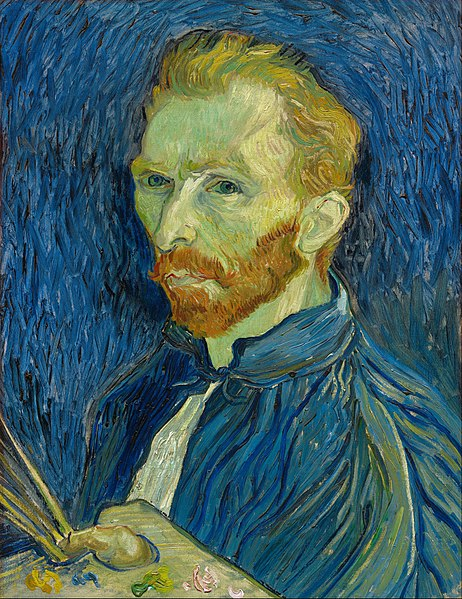

In [13]:
van_gogh = cv2.imread(f"{image_folder}/van_gogh.jpg")
print(van_gogh.shape)
cv2_imshow(van_gogh)

## Naive Downsampling

In [14]:
scale_factor = 4                                                                # define a scale factor

height, width, channels = van_gogh.shape

width_downsampled = int(width / scale_factor)                                   # calculate the downsampled width
height_downsampled = int(height / scale_factor)                                 # calculate the downsampled height

### openCV implementation

> OpenCV provides us several interpolation methods for resizing an image:
> * `cv2.INTER_AREA`: This is used when we need to shrink an image.
> * `cv2.INTER_CUBIC`: This is slow but more efficient.
> * `cv2.INTER_LINEAR`: This is primarily used when zooming is required. This is the default interpolation technique in OpenCV.

(149, 115, 3)


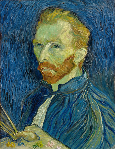

In [15]:
downsampled_img = cv2.resize(van_gogh, (width_downsampled, height_downsampled)) # apply downsampling with cv2

print(downsampled_img.shape)
cv2_imshow(downsampled_img)

### ***Exercise 2.1*** - Implement the naive downsampling algorithm from scratch.

P.S. You cannot use `cv2.resize()` function.


In [16]:
def downsample(image, scale_factor):

    height, width, channels = image.shape

    width_downsampled = int(width / scale_factor)
    height_downsampled = int(height / scale_factor)

    downsampled_img = np.zeros((height_downsampled, width_downsampled, channels), dtype=np.uint8)

    for y in range(height_downsampled):
        for x in range(width_downsampled):

            # For example, we want to reduce the dimensions of the image by a factor of 8 in both
            # width and height. This means that for every 8 pixels in the original image, we will
            # only keep 1 pixel in the downsampled image.

            original_x = int(x * scale_factor)
            original_y = int(y * scale_factor)

            downsampled_img[y, x] = image[original_y, original_x]

    return downsampled_img

(149, 115, 3)


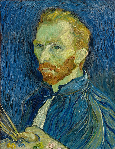

In [17]:
downsampled_img = downsample(van_gogh, scale_factor)

print(downsampled_img.shape)
cv2_imshow(downsampled_img)

### Let's compare images downsampled with factors of 2 and 8.



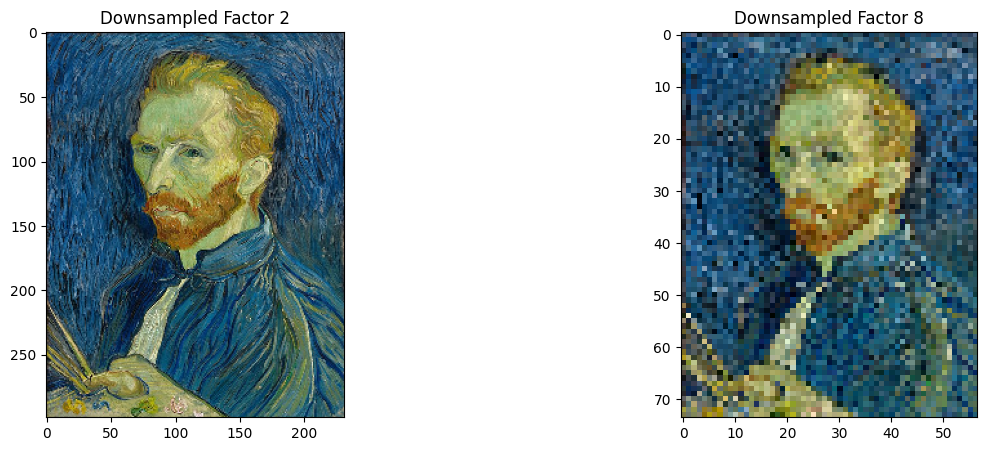

In [18]:
downsampled_img_factor_2 = downsample(van_gogh, 2)
downsampled_img_factor_8 = downsample(van_gogh, 8)

plot_side_by_side(downsampled_img_factor_2, downsampled_img_factor_8, "Downsampled Factor 2", "Downsampled Factor 8")

## ***Exercise 2.2*** - Improved Downsampling

Apply a smoothing filter first, then throw away half the
rows and columns like we did in the previous exercise. Do not use cv2 or any equivalent libraries.

Tip: *Remember smoothing effect filters. Revisit our last lab to implement the filter. Do not forget to adapt our filter implementation to work with the 3-channel images.*

***Gaussian Kernel***


![image](https://github.com/d2l-ai/d2l-en/assets/52993055/9590ed1d-9b86-4a58-87ea-2bbd21ac6aec)

![image](https://github.com/d2l-ai/d2l-en/assets/52993055/26f6cdff-9f1d-456a-bb68-d735e67516fc)


In [19]:
def gaussian_kernel(k_size, sigma=0.85):
    # return 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])

    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(k_size-1)/2)**2 + (y-(k_size-1)/2)**2)/(2*sigma**2)), (k_size, k_size))
    return kernel / np.sum(kernel)  # to normalize the kernel

gaussian_kernel(3)

array([[0.06256912, 0.12499996, 0.06256912],
       [0.12499996, 0.24972366, 0.12499996],
       [0.06256912, 0.12499996, 0.06256912]])

> ***Note:*** Subtracting $(kernelsize−1)/2$ from the coordinate ensures that we correctly calculate the distance of each pixel from the center of the kernel

> ***Note:*** Normalizing the Gaussian kernel by dividing it by the sum of all its elements ensures that the sum of the kernel's weights is equal to 1.

In [20]:
def gaussian_blur(img, kernel_size=3):

    kernel = gaussian_kernel(kernel_size)

    kernel = np.flipud(np.fliplr(kernel))                                                       # flip the kernel

    height, width, channels = img.shape

    pad_width = int(kernel_size - 1 / 2)                                                        # the padding width for each side

    padded_image = np.zeros((height + pad_width * 2, width + pad_width * 2, channels))          # create an empty padded image

    padded_image[pad_width:-pad_width, pad_width:-pad_width, :] = img                           # copy the original image into the padded image

    filtered_image = np.zeros_like(img)                                                         # create an empty image to store the filtered result

    for c in range(channels):
        for x in range(width):
            for y in range(height):
                filtered_image[y, x, c] = (kernel * padded_image[y: y+kernel_size, x: x+kernel_size, c]).sum()

    return filtered_image

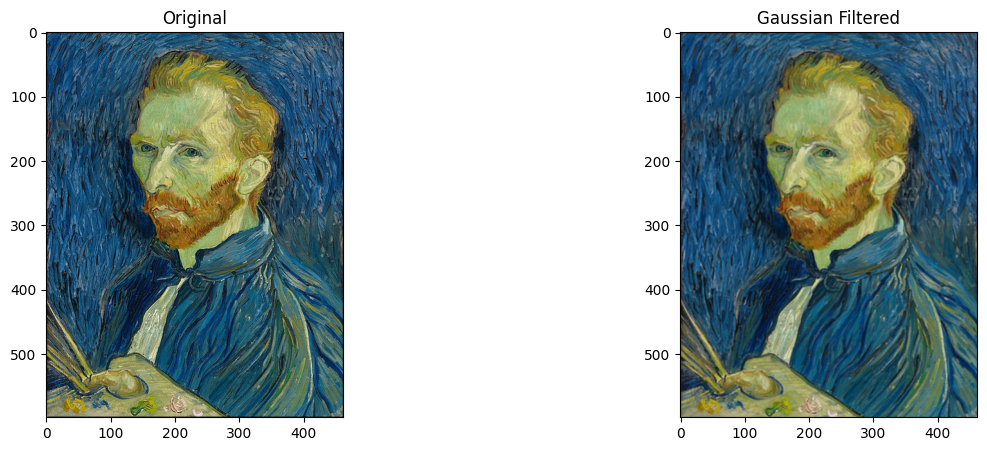

In [21]:
gaussian_image = gaussian_blur(van_gogh, 3)

plot_side_by_side(van_gogh, gaussian_image, "Original", "Gaussian Filtered")

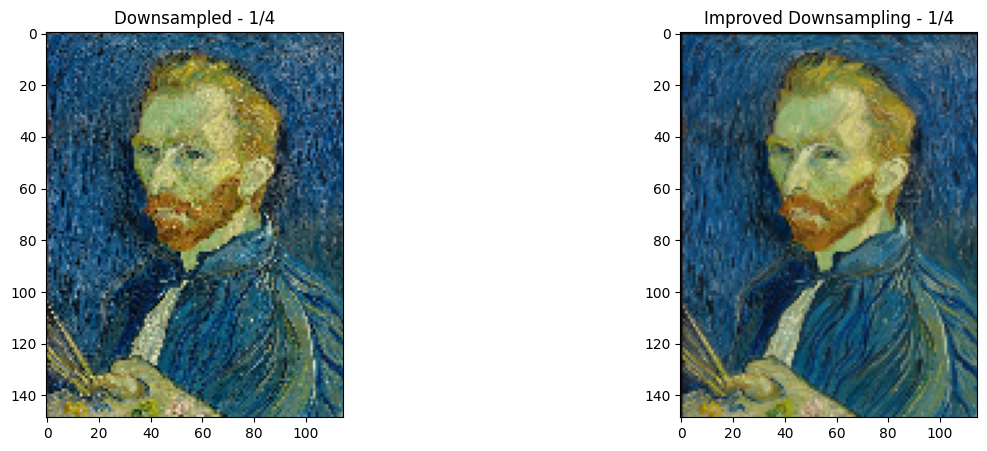

In [22]:
scale_factor = 4

downsampled = downsample(van_gogh, scale_factor)
improved_downsampled = downsample(gaussian_image, scale_factor)

plot_side_by_side(downsampled, improved_downsampled, f"Downsampled - 1/{scale_factor}", f"Improved Downsampling - 1/{scale_factor}")

# 2. Image Pyramids

## Gaussian Image Pyramid

### openCV implementation

In [23]:
def generate_gaussian_pyramid_cv2(image, num_levels):
    pyramid = [image]                                       # add the original image to the pyramid as the first level

    for _ in range(num_levels - 1):                         # generate the gaussian pyramid by reducing the image size by a factor of 2 for each level
        image = cv2.pyrDown(image)                          # reduce the image size by a factor of 2
        pyramid.append(image)                               # add the reduced image to the pyramid

    return pyramid

Level 0


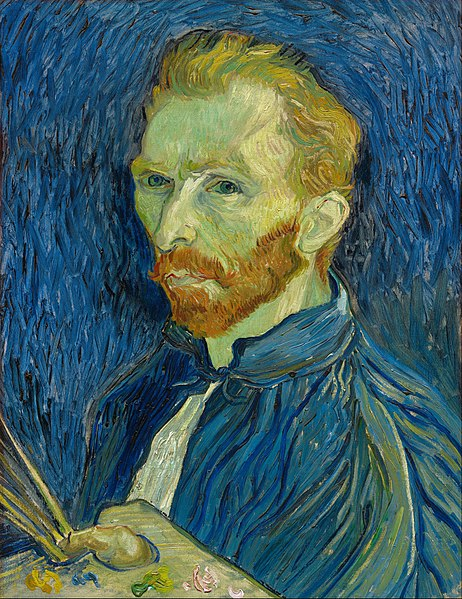

Level 1


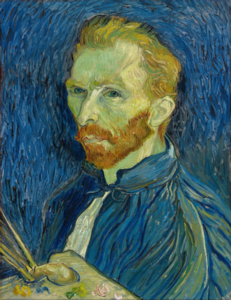

Level 2


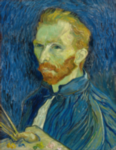

Level 3


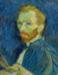

In [24]:
num_levels = 4                                                      # define number of levels in the gaussian pyramid

pyramid = generate_gaussian_pyramid_cv2(van_gogh, num_levels)       # generate the gaussian pyramid

for i, level_image in enumerate(pyramid):
    print(f"Level {i}")
    cv2_imshow(level_image)

### ***Exercise 3.1*** - Gaussian Image Pyramid from scratch

Remember Gaussian pyramid algorithm from the lecture. You need to blur the image and then downsample it by a factor of 2.

We've already implemented the  functions that you need :)

In [25]:
def generate_gaussian_pyramid(image, num_levels):
    pyramid = [image]                               # add the original image to the pyramid as the first level

    for _ in range(num_levels - 1):
        image = gaussian_blur(image)                # apply gaussian filter
        image = image[::2, ::2, :]                  # select every other pixel along both the height and width dimensions (by slicing with a step of 2)
        pyramid.append(image)

    return pyramid

Level 0


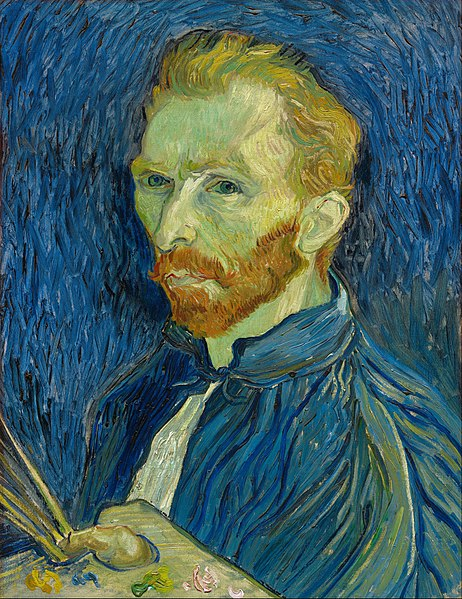

Level 1


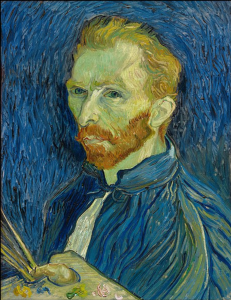

Level 2


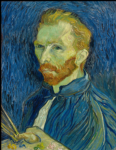

Level 3


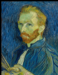

In [26]:
num_levels = 4

pyramid = generate_gaussian_pyramid(van_gogh, num_levels)

for i, level_image in enumerate(pyramid):
    print(f"Level {i}")
    cv2_imshow(level_image)

## ***Exercise 3.2*** - Laplacian Image Pyramid (with OpenCV)

> PS. You can use cv2.pyrUp() for upsampling.

At each level, retain the residuals instead of
the blurred images themselves.

![image](https://github.com/seccily/yoga-analyzer/assets/52993055/7276858a-37aa-4412-b3a2-206fde70b023)


Level 0


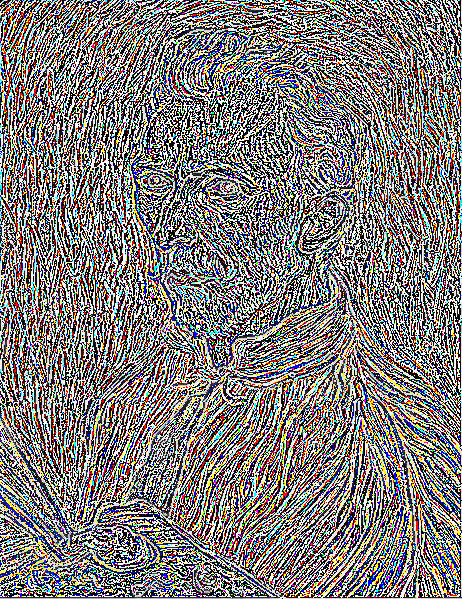

Level 1


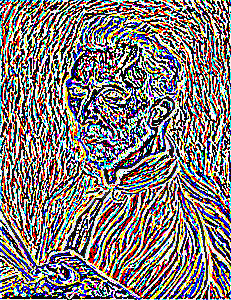

Level 2


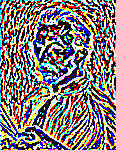

Level 3


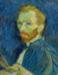

In [27]:
def generate_laplacian_pyramid(image, levels):
    pyramid = []

    gaussian_pyramid = generate_gaussian_pyramid_cv2(image, levels)

    for i in range(levels-1):
        h, w, _ = gaussian_pyramid[i].shape
        upsampled = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=(w, h))            # up-sample the current level
        residual = gaussian_pyramid[i] - upsampled                              # subtract the up-sampled image from the current level
        pyramid.append(residual)                                                # add the level to the pyramid

    pyramid.append(gaussian_pyramid[-1])                                        # add the last level of Gaussian pyramid
    return pyramid

num_levels = 4                                                                  # define the number of levels in the pyramid

laplacian_pyramid = generate_laplacian_pyramid(van_gogh, num_levels)            # generate the laplacian pyramid

for i, level_image in enumerate(laplacian_pyramid):
    print(f"Level {i}")
    cv2_imshow(level_image)

## ***Exercise 3.3*** - Reconstruct Image from Laplacian Pyramid
![image](https://github.com/seccily/yoga-analyzer/assets/52993055/35d9ca28-6d54-422f-87d6-6e3bc47a69c4)


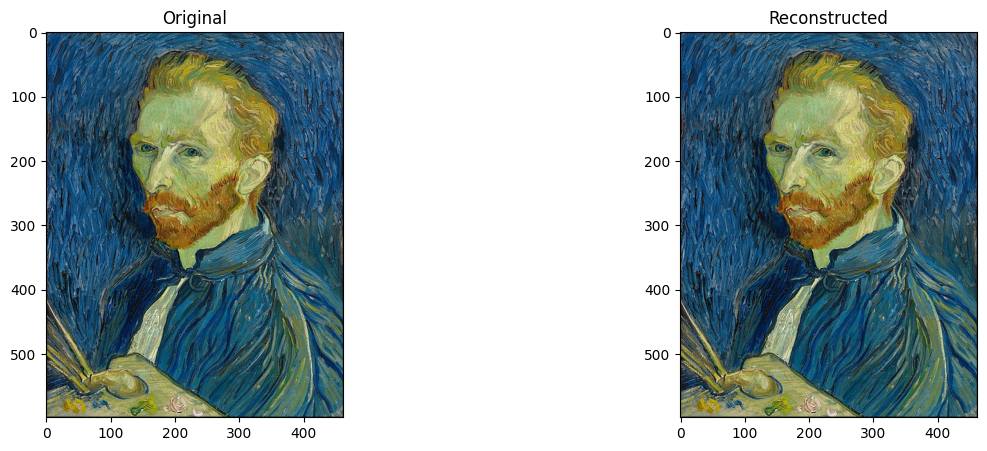

In [28]:
def reconstruct_image_from_pyramid(laplacian_pyramid):
    reconstructed_image = laplacian_pyramid[-1]

    for i in range(len(laplacian_pyramid)-2, -1, -1):                           # go in reverse order
        height, width, _ = laplacian_pyramid[i].shape
        upsampled = cv2.pyrUp(reconstructed_image, dstsize=(width, height))     # up-sample the current level
        reconstructed_image = upsampled + laplacian_pyramid[i]                  # add the up-sampled image to the current level

    return reconstructed_image

reconstructed = reconstruct_image_from_pyramid(laplacian_pyramid)               # reconstruct the image

plot_side_by_side(van_gogh, reconstructed, "Original", "Reconstructed")